# COMP 3610 Project

### A PREDICTIVE MODEL FOR ELECTORAL OUTCOMES IN TRINIDAD & TOBAGO USING MACROECONOMIC INDICATORS

- Christophe Gittens  
- Maia Neptune       
- Zidane Timothy     

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

## Reading from CSV generated by data collection notebook

In [2]:
master_df = pd.read_csv(r"csvs/master_df_2025.csv")

## Model Training

### Multinomial Logistic Regression

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

df = master_df.copy()
df = df[df['Year'] == 2020]
constituencies = [
    "ELECTORAL_DISTRICT_ARIMA", "ELECTORAL_DISTRICT_AROUCA/MALONEY", "ELECTORAL_DISTRICT_BARATARIA/SAN JUAN", "ELECTORAL_DISTRICT_CARONI CENTRAL", "ELECTORAL_DISTRICT_CARONI EAST",
    "ELECTORAL_DISTRICT_CHAGUANAS EAST", "ELECTORAL_DISTRICT_CHAGUANAS WEST", "ELECTORAL_DISTRICT_COUVA NORTH", "ELECTORAL_DISTRICT_COUVA SOUTH", "ELECTORAL_DISTRICT_CUMUTO/MANZANILLA",
    "ELECTORAL_DISTRICT_D'ABADIE/O'MEARA", "ELECTORAL_DISTRICT_DIEGO MARTIN CENTRAL", "ELECTORAL_DISTRICT_DIEGO MARTIN NORTH/EAST", "ELECTORAL_DISTRICT_DIEGO MARTIN WEST",
    "ELECTORAL_DISTRICT_FYZABAD", "ELECTORAL_DISTRICT_LA BREA", "ELECTORAL_DISTRICT_LA HORQUETTA/TALPARO", "ELECTORAL_DISTRICT_LAVENTILLE EAST/MORVANT", "ELECTORAL_DISTRICT_LAVENTILLE WEST",
    "ELECTORAL_DISTRICT_LOPINOT/BON AIR WEST", "ELECTORAL_DISTRICT_MAYARO", "ELECTORAL_DISTRICT_MORUGA/TABLELAND", "ELECTORAL_DISTRICT_NAPARIMA", "ELECTORAL_DISTRICT_OROPOUCHE EAST",
    "ELECTORAL_DISTRICT_OROPOUCHE WEST", "ELECTORAL_DISTRICT_POINT FORTIN", "ELECTORAL_DISTRICT_POINTE-A-PIERRE", "ELECTORAL_DISTRICT_PORT-OF-SPAIN NORTH/ST. ANN'S WEST",
    "ELECTORAL_DISTRICT_PORT-OF-SPAIN SOUTH", "ELECTORAL_DISTRICT_PRINCES TOWN", "ELECTORAL_DISTRICT_SAN FERNANDO EAST", "ELECTORAL_DISTRICT_SAN FERNANDO WEST", "ELECTORAL_DISTRICT_SIPARIA","ELECTORAL_DISTRICT_ST. ANN'S EAST", "ELECTORAL_DISTRICT_ST. AUGUSTINE", 
    "ELECTORAL_DISTRICT_ST. JOSEPH", "ELECTORAL_DISTRICT_TABAQUITE", "ELECTORAL_DISTRICT_TOBAGO EAST", "ELECTORAL_DISTRICT_TOBAGO WEST", "ELECTORAL_DISTRICT_TOCO/SANGRE GRANDE", 
    "ELECTORAL_DISTRICT_TUNAPUNA"
]

# Step 2: Get indexes where Year == 2024
df_2025 = master_df[master_df['Year'] != 2024]
indexes_2025 = df_2025.index.tolist()

# Step 3: Make key-value pairs
index_constituency_mapping = dict(zip(indexes_2025, constituencies))

# Add a column for the winning party
df['Winning_Party'] = df[['P.N.M._VOTES_%', 'U.N.C._VOTES_%']].idxmax(axis=1)

# Add a column for the margin of victory
df['Margin_of_Victory'] = df[['P.N.M._VOTES_%', 'U.N.C._VOTES_%']].apply(
    lambda row: row.max() - sorted(row)[-2], axis=1
)

# Define thresholds
safe_margin_threshold = 0.20    # Safe seat if margin of victory > 20%

# Identify safe seats
safe_seats = df[(df['Margin_of_Victory'] > safe_margin_threshold)]

safe_seat_columns = safe_seats.loc[:, safe_seats.columns.str.startswith('ELECTORAL_DISTRICT_')]
unique_safe_seats = safe_seat_columns.columns[(safe_seat_columns == True).any()].tolist()

# Identify marginal seats
marginal_seats = df[df['Margin_of_Victory'] < safe_margin_threshold]
marginal_seat_columns = marginal_seats.loc[:, marginal_seats.columns.str.startswith('ELECTORAL_DISTRICT_')]

unique_marginal_seats = marginal_seat_columns.columns[(marginal_seat_columns == True).any()].tolist()
seat_columns = marginal_seat_columns.columns[(marginal_seat_columns == True).any()]

# Create a dictionary where key = index, value = seat name
seat_index_mapping = {}

for seat in seat_columns:
    # Find the index (row) where the seat is True
    matching_indexes = marginal_seat_columns.index[marginal_seat_columns[seat] == True].tolist()
    for idx in matching_indexes:
        seat_index_mapping[idx] = seat

unique_safe_seats = [seat for seat in unique_safe_seats if seat not in unique_marginal_seats]
unique_marginal_seats.remove('ELECTORAL_DISTRICT_TOTAL')

print("Number of Safe Seats:", len(unique_safe_seats))
print("Number of Marginal Seats:", len(unique_marginal_seats))

seat_mapping_marginal = {}
seat_mapping_safe = {}

for index, constituency in index_constituency_mapping.items():
    if constituency in unique_safe_seats:
        seat_mapping_safe[index] = constituency
    elif constituency in unique_marginal_seats:
        seat_mapping_marginal[index] = constituency

seat_mapping_safe, seat_mapping_marginal

Number of Safe Seats: 27
Number of Marginal Seats: 12


({0: 'ELECTORAL_DISTRICT_ARIMA',
  1: 'ELECTORAL_DISTRICT_AROUCA/MALONEY',
  3: 'ELECTORAL_DISTRICT_CARONI CENTRAL',
  4: 'ELECTORAL_DISTRICT_CARONI EAST',
  6: 'ELECTORAL_DISTRICT_CHAGUANAS WEST',
  7: 'ELECTORAL_DISTRICT_COUVA NORTH',
  8: 'ELECTORAL_DISTRICT_COUVA SOUTH',
  10: "ELECTORAL_DISTRICT_D'ABADIE/O'MEARA",
  11: 'ELECTORAL_DISTRICT_DIEGO MARTIN CENTRAL',
  12: 'ELECTORAL_DISTRICT_DIEGO MARTIN NORTH/EAST',
  13: 'ELECTORAL_DISTRICT_DIEGO MARTIN WEST',
  14: 'ELECTORAL_DISTRICT_FYZABAD',
  15: 'ELECTORAL_DISTRICT_LA BREA',
  17: 'ELECTORAL_DISTRICT_LAVENTILLE EAST/MORVANT',
  18: 'ELECTORAL_DISTRICT_LAVENTILLE WEST',
  19: 'ELECTORAL_DISTRICT_LOPINOT/BON AIR WEST',
  22: 'ELECTORAL_DISTRICT_NAPARIMA',
  23: 'ELECTORAL_DISTRICT_OROPOUCHE EAST',
  24: 'ELECTORAL_DISTRICT_OROPOUCHE WEST',
  25: 'ELECTORAL_DISTRICT_POINT FORTIN',
  29: 'ELECTORAL_DISTRICT_PRINCES TOWN',
  30: 'ELECTORAL_DISTRICT_SAN FERNANDO EAST',
  32: 'ELECTORAL_DISTRICT_SIPARIA',
  33: "ELECTORAL_DISTRICT_ST

In [4]:
seat_mapping_safe_df = pd.DataFrame(list(seat_mapping_safe.items()), columns=['Index', 'Constituency_Safe'])
seat_mapping_marginal_df = pd.DataFrame(list(seat_mapping_marginal.items()), columns=['Index', 'Constituency_Marginal'])

seat_mapping_safe_df['Constituency_Safe'] = seat_mapping_safe_df['Constituency_Safe'].str.replace('ELECTORAL_DISTRICT_', '', regex=False)
seat_mapping_marginal_df['Constituency_Marginal'] = seat_mapping_marginal_df['Constituency_Marginal'].str.replace('ELECTORAL_DISTRICT_', '', regex=False)

# Join with master_df for safe seats
df_safe_seats = master_df.merge(seat_mapping_safe_df, left_on='CONSTITUENCIES', right_on='Constituency_Safe', how='left')
df_marginal_seats = master_df.merge(seat_mapping_marginal_df, left_on='CONSTITUENCIES', right_on='Constituency_Marginal', how='left')

df_safe_seats = df_safe_seats[df_safe_seats['Constituency_Safe'].notna()]
df_marginal_seats = df_marginal_seats[df_marginal_seats['Constituency_Marginal'].notna()]

df_safe_seats['Winning_Party'] = df_safe_seats[['P.N.M._VOTES_%', 'U.N.C._VOTES_%']].idxmax(axis=1)
df_marginal_seats['Winning_Party'] = df_marginal_seats[['P.N.M._VOTES_%', 'U.N.C._VOTES_%']].idxmax(axis=1)
# Show the resulting DataFrames for safe and marginal seats

df_marginal_seats = df_marginal_seats.select_dtypes(exclude=['bool'])
df_safe_seats = df_safe_seats.select_dtypes(exclude=['bool'])
df_safe_seats

,CONSTITUENCIES,ELECTORATE,P.N.M._VOTES_%,U.N.C._VOTES_%,VOTER_TURNOUT,TOTAL_NUMBER_OF_VOTES_CAST,VALID_VOTES,Year,ELECTORAL_DISTRICT_PORT-OF-SPAIN NORTH/ST. ANN'S WEST,ELECTORAL_DISTRICT_PORT-OF-SPAIN SOUTH,...,GDP (Per Capita US$)_1y,GDP_(US$)_1t,GDP_(US$)_1y,Homicide_rate_per_100k_1t,Homicide_rate_per_100k_1y,ELECTORAL_DISTRICT_PORT OF SPAIN NORTH/ST. ANN'S WEST,ELECTORAL_DISTRICT_PORT OF SPAIN SOUTH,Index,Constituency_Safe,Winning_Party
0,ARIMA,22845,0.643311,0.091528,0.589363,13464,13373,2007,False,False,...,0.166013,0.876472,0.163934,0.798783,0.046773,0,0,0.0,ARIMA,P.N.M._VOTES_%
1,AROUCA/MALONEY,23673,0.757795,0.093035,0.673679,15948,15908,2007,False,False,...,0.166013,0.876472,0.163934,0.798783,0.046773,0,0,1.0,AROUCA/MALONEY,P.N.M._VOTES_%
3,CARONI CENTRAL,22813,0.275943,0.458901,0.729409,16640,16594,2007,False,False,...,0.166013,0.876472,0.163934,0.798783,0.046773,0,0,3.0,CARONI CENTRAL,U.N.C._VOTES_%
4,CARONI EAST,23554,0.233777,0.508234,0.698820,16460,16396,2007,False,False,...,0.166013,0.876472,0.163934,0.798783,0.046773,0,0,4.0,CARONI EAST,U.N.C._VOTES_%
6,CHAGUANAS WEST,24272,0.084638,0.621274,0.742790,18029,17947,2007,False,False,...,0.166013,0.876472,0.163934,0.798783,0.046773,0,0,6.0,CHAGUANAS WEST,U.N.C._VOTES_%
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,SIPARIA,29096,0.144552,0.833034,0.575300,16740,16686,2024,0,0,...,0.027614,0.301868,0.027661,0.455680,0.076691,False,False,32.0,SIPARIA,U.N.C._VOTES_%
201,ST. ANN'S EAST,30113,0.555580,0.316975,0.448400,13502,13449,2024,0,0,...,0.027614,0.301868,0.027661,0.455680,0.076691,False,False,33.0,ST. ANN'S EAST,P.N.M._VOTES_%
202,ST. AUGUSTINE,28397,0.225128,0.737651,0.606000,17209,17168,2024,0,0,...,0.027614,0.301868,0.027661,0.455680,0.076691,False,False,34.0,ST. AUGUSTINE,U.N.C._VOTES_%
204,TABAQUITE,28876,0.218589,0.738915,0.546000,15765,15719,2024,0,0,...,0.027614,0.301868,0.027661,0.455680,0.076691,False,False,36.0,TABAQUITE,U.N.C._VOTES_%


In [5]:
leans_pnm = [
    "ARIMA", "AROUCA/MALONEY", "D'ABADIE/O'MEARA", "DIEGO MARTIN CENTRAL",
    "DIEGO MARTIN NORTH/EAST", "DIEGO MARTIN WEST", "LA BREA",
    "LAVENTILLE EAST/MORVANT", "LAVENTILLE WEST", "LOPINOT/BON AIR WEST",
    "POINT FORTIN", "PORT-OF-SPAIN NORTH/ST. ANN'S WEST", "PORT-OF-SPAIN SOUTH",
    "SAN FERNANDO EAST", "ST. ANN'S EAST", "TOBAGO WEST"
]

leans_unc = [
    "CARONI CENTRAL", "CARONI EAST", "CHAGUANAS WEST", "COUVA NORTH",
    "COUVA SOUTH", "FYZABAD", "NAPARIMA", "OROPOUCHE EAST",
    "OROPOUCHE WEST", "PRINCES TOWN", "SIPARIA", "ST. AUGUSTINE", "TABAQUITE"
]

battleground = [
    "BARATARIA/SAN JUAN", "CHAGUANAS EAST", "CUMUTO/MANZANILLA",
    "LA HORQUETTA/TALPARO", "MAYARO", "MORUGA/TABLELAND", "POINTE-A-PIERRE",
    "SAN FERNANDO WEST", "ST. JOSEPH", "TOBAGO EAST", "TOCO/SANGRE GRANDE",
    "TUNAPUNA"
]

# Make the mapping dictionary
safe_constituency_leaning = {}
marginal_constituency_leaning = {}
unknown_constituency_leaning = {}

for seat in master_df['CONSTITUENCIES']:
    if seat in leans_pnm:
        safe_constituency_leaning[seat] = 2  # Leans PNM
    elif seat in leans_unc:
        safe_constituency_leaning[seat] = 1  # Leans UNC
    elif seat in battleground:
        marginal_constituency_leaning[seat] = 3  # Battleground seat
    else:
        unknown_constituency_leaning[seat] = None  # Unknown

df_safe_seats['CONSTITUENCY_LEANING'] = df_safe_seats['CONSTITUENCIES'].map(safe_constituency_leaning)
df_marginal_seats['CONSTITUENCY_LEANING'] = df_marginal_seats['CONSTITUENCIES'].map(marginal_constituency_leaning)
master_df['CONSTITUENCY_LEANING'] = master_df['CONSTITUENCIES'].map(safe_constituency_leaning).fillna(
    master_df['CONSTITUENCIES'].map(marginal_constituency_leaning).fillna(
        master_df['CONSTITUENCIES'].map(unknown_constituency_leaning)
    )
)
master_df

C:\Users\maian\AppData\Local\Temp\ipykernel_34376\830625993.py:40: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  master_df['CONSTITUENCIES'].map(marginal_constituency_leaning).fillna(


,CONSTITUENCIES,ELECTORATE,P.N.M._VOTES_%,U.N.C._VOTES_%,VOTER_TURNOUT,TOTAL_NUMBER_OF_VOTES_CAST,VALID_VOTES,Year,ELECTORAL_DISTRICT_ARIMA,ELECTORAL_DISTRICT_AROUCA/MALONEY,...,Net Migration Rate_1y,GDP (Per Capita US$)_1t,GDP (Per Capita US$)_1y,GDP_(US$)_1t,GDP_(US$)_1y,Homicide_rate_per_100k_1t,Homicide_rate_per_100k_1y,ELECTORAL_DISTRICT_PORT OF SPAIN NORTH/ST. ANN'S WEST,ELECTORAL_DISTRICT_PORT OF SPAIN SOUTH,CONSTITUENCY_LEANING
0,ARIMA,22845,0.643311,0.091528,0.589363,13464,13373,2007,True,False,...,0.007491,0.887951,0.166013,0.876472,0.163934,0.798783,0.046773,0,0,2.0
1,AROUCA/MALONEY,23673,0.757795,0.093035,0.673679,15948,15908,2007,False,True,...,0.007491,0.887951,0.166013,0.876472,0.163934,0.798783,0.046773,0,0,2.0
2,BARATARIA/SAN JUAN,24597,0.438868,0.327791,0.668821,16451,16358,2007,False,False,...,0.007491,0.887951,0.166013,0.876472,0.163934,0.798783,0.046773,0,0,3.0
3,CARONI CENTRAL,22813,0.275943,0.458901,0.729409,16640,16594,2007,False,False,...,0.007491,0.887951,0.166013,0.876472,0.163934,0.798783,0.046773,0,0,1.0
4,CARONI EAST,23554,0.233777,0.508234,0.698820,16460,16396,2007,False,False,...,0.007491,0.887951,0.166013,0.876472,0.163934,0.798783,0.046773,0,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205,TOBAGO EAST,23853,0.351427,0.571109,0.525800,12542,12509,2024,False,False,...,-0.001759,0.043387,0.027614,0.301868,0.027661,0.455680,0.076691,False,False,3.0
206,TOBAGO WEST,28863,0.461044,0.468654,0.498200,14379,14324,2024,False,False,...,-0.001759,0.043387,0.027614,0.301868,0.027661,0.455680,0.076691,False,False,2.0
207,TOCO/SANGRE GRANDE,31186,0.417901,0.552131,0.567300,17691,17619,2024,False,False,...,-0.001759,0.043387,0.027614,0.301868,0.027661,0.455680,0.076691,False,False,3.0
208,TUNAPUNA,27485,0.434562,0.529887,0.582700,16016,15977,2024,False,False,...,-0.001759,0.043387,0.027614,0.301868,0.027661,0.455680,0.076691,False,False,3.0


## Logistic Regression Model

In [6]:
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

features = [
            'CONSTITUENCY_LEANING','Year', 'Homicide_rate_per_100k', 'Homicide (Annual Percentage Change)', 'Inflation', 'Net Migration Rate', 'Inflation_1t', 'Inflation_1y', 'Unemployment_1t',
            'Unemployment_1y', 'Net Migration Rate_1t', 'Net Migration Rate_1y', 'GDP (Per Capita US$)_1t', 'GDP (Per Capita US$)_1y', 'GDP_(US$)_1t', 'GDP_(US$)_1y','ELECTORATE'
            ] 

df_safe_seats_model = df_safe_seats[df_safe_seats['Year'] != 2024]
print(df_safe_seats_model['Winning_Party'].unique())
print(len(df_safe_seats_model))

# Prepare data for classification
X_safe = df_safe_seats_model[features]
y_safe = df_safe_seats_model['Winning_Party']

df_safe_seats_model

# Make it binary: 1 if PNM, 0 otherwise
y_safe_binary = (y_safe == 'P.N.M._VOTES_%').astype(int)

# Split the data
X_safe_train, X_safe_test, y_safe_train, y_safe_test = train_test_split(
    X_safe, y_safe_binary, 
    test_size=0.4, 
    random_state=42, 
    stratify=y_safe_binary
)

# Fit a classification model
clf = LogisticRegression(solver='saga', max_iter=1000)
clf.fit(X_safe_train, y_safe_train)

# Make predictions
y_safe_pred = clf.predict(X_safe_test)

# Evaluate the classification model
print("Classification Report for Safe Seats:\n")
print(classification_report(y_safe_test, y_safe_pred))

print("\nConfusion Matrix for Safe Seats:\n")
print(confusion_matrix(y_safe_test, y_safe_pred))
print(y_safe_binary.value_counts())

['P.N.M._VOTES_%' 'U.N.C._VOTES_%']
108
Classification Report for Safe Seats:

              precision    recall  f1-score   support

           0       0.52      1.00      0.69        23
           1       0.00      0.00      0.00        21

    accuracy                           0.52        44
   macro avg       0.26      0.50      0.34        44
weighted avg       0.27      0.52      0.36        44


Confusion Matrix for Safe Seats:

[[23  0]
 [21  0]]
Winning_Party
0    56
1    52
Name: count, dtype: int64


c:\Users\maian\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\maian\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\maian\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\maian\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted 

### Model Tuning

In [7]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Define the hyperparameter grid
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10],  # Regularization strength
    'penalty': ['l1', 'l2'],  # Regularization type
    'solver': ['liblinear', 'saga'],  # Solvers for Logistic Regression
    'max_iter': [100, 500, 1000],  # Number of iterations
    'class_weight': ['balanced', None]  # Handling class imbalance
}

# Initialize the logistic regression model
logreg = LogisticRegression(multi_class='ovr', max_iter=1000)

# Initialize GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(estimator=logreg, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1)

# Fit the grid search to the training data
grid_search.fit(X_safe_train, y_safe_train)

# Get the best hyperparameters
print("Best hyperparameters found: ", grid_search.best_params_)

# Get the best model from grid search
best_logreg = grid_search.best_estimator_

# Make predictions using the best model
y_safe_pred = best_logreg.predict(X_safe_test)

# Evaluate the model with a classification report and confusion matrix
print("Classification Report for Safe Seats with Tuning:\n")
print(classification_report(y_safe_test, y_safe_pred))

print("\nConfusion Matrix for Safe Seats with Tuning:\n")
print(confusion_matrix(y_safe_test, y_safe_pred))

Fitting 5 folds for each of 120 candidates, totalling 600 fits
Best hyperparameters found:  {'C': 1, 'class_weight': 'balanced', 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}
Classification Report for Safe Seats with Tuning:

              precision    recall  f1-score   support

           0       1.00      0.91      0.95        23
           1       0.91      1.00      0.95        21

    accuracy                           0.95        44
   macro avg       0.96      0.96      0.95        44
weighted avg       0.96      0.95      0.95        44


Confusion Matrix for Safe Seats with Tuning:

[[21  2]
 [ 0 21]]


c:\Users\maian\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\maian\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


# Setup and Make Predictions with the Trained Data

In [8]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Define the same feature columns as used in training
features = [
            'CONSTITUENCY_LEANING','Year', 'Homicide_rate_per_100k', 'Homicide (Annual Percentage Change)', 'Inflation', 'Net Migration Rate', 'Inflation_1t', 'Inflation_1y', 'Unemployment_1t',
            'Unemployment_1y', 'Net Migration Rate_1t', 'Net Migration Rate_1y', 'GDP (Per Capita US$)_1t', 'GDP (Per Capita US$)_1y', 'GDP_(US$)_1t', 'GDP_(US$)_1y','ELECTORATE'
            ]

# Filter safe_seats to only include rows for 2025
safe_seats_2025_filtered = master_df[master_df['Year'] == 2024]
safe_seats_2025_filtered = safe_seats_2025_filtered[(safe_seats_2025_filtered['CONSTITUENCY_LEANING'] == 1) | (safe_seats_2025_filtered['CONSTITUENCY_LEANING'] == 2)]

# Show the filtered DataFrame
print(f"Rows after filtering for non-NaN 'Constituency_Leaning': {safe_seats_2025_filtered.shape[0]}")

# Select the same features for prediction
X_2025 = safe_seats_2025_filtered[features].copy()


# Scale using a scaler **fitted on X_safe**
scaler = StandardScaler()
X_safe_scaled = scaler.fit_transform(X_safe)        # fit on training data
X_2025_scaled = scaler.transform(X_2025)            # transform test (2025) data

# Use the best model from GridSearchCV or RandomizedSearchCV
best_model = grid_search.best_estimator_  # Use the model from GridSearchCV

# Predict class (0 or 1) using the tuned model
safe_seat_predictions = best_model.predict(X_2025_scaled)

# Optional: decode to party names
party_mapping = {1: 'P.N.M.', 0: 'U.N.C.'}
decoded_safe_predictions = [party_mapping[pred] for pred in safe_seat_predictions]

# Put predictions in a DataFrame
predictions_2025 = pd.DataFrame({
    'Constituency': safe_seats_2025_filtered['CONSTITUENCIES'],  # assuming index is constituency name
    'Predicted_Winning_Party': decoded_safe_predictions
})

# View the predictions
print(y_safe_train.value_counts())
print("Model Coefficients:\n", clf.coef_)
y_safe_train_pred = clf.predict(X_safe_train)
print("Training Accuracy: ", accuracy_score(y_safe_train, y_safe_train_pred))

# predictions_2025
predictions_2025


Rows after filtering for non-NaN 'Constituency_Leaning': 29
Winning_Party
0    33
1    31
Name: count, dtype: int64
Model Coefficients:
 [[ 3.15257414e-05 -2.97488975e-05 -1.15854229e-05 -3.32594992e-05
  -2.12586041e-05  5.76798276e-06 -6.08018438e-06 -1.70746568e-06
   1.61734747e-06  8.82608004e-07 -1.05544072e-06  3.05354495e-07
  -1.42268491e-06 -6.69090617e-07 -1.56270435e-06 -8.55531158e-07
  -6.57699475e-08]]
Training Accuracy:  0.515625


c:\Users\maian\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


,Constituency,Predicted_Winning_Party
168,ARIMA,P.N.M.
169,AROUCA/MALONEY,P.N.M.
171,CARONI CENTRAL,U.N.C.
172,CARONI EAST,U.N.C.
174,CHAGUANAS WEST,U.N.C.
175,COUVA NORTH,U.N.C.
176,COUVA SOUTH,U.N.C.
178,D'ABADIE/O'MEARA,P.N.M.
179,DIEGO MARTIN CENTRAL,P.N.M.
180,DIEGO MARTIN NORTH/EAST,P.N.M.


### Multinomial Linear Regression

##### PNM

In [9]:
import pandas as pd

# Replace with the path to your Excel file
df = pd.read_excel('csvs/collated-tt-election-results.xlsx', sheet_name='ELECTORAL_ELASTICITY', skiprows=0, header=1)

# Mapping for encoding the categorical values
encoding_map = {
    'VERY LOW': 1,
    'LOW': 2,
    'MODERATE': 3,
    'HIGH': 4,
    'VERY HIGH': 5
}

# Apply encoding to the 'ELASTICITY' and 'SWING_PROB' columns
df['ELASTICITY'] = df['ELASTICITY'].replace(encoding_map)
df['SWING_PROB'] = df['SWING_PROB'].replace(encoding_map)

# Display the transformed DataFrame
# df

C:\Users\maian\AppData\Local\Temp\ipykernel_34376\1157008649.py:16: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['ELASTICITY'] = df['ELASTICITY'].replace(encoding_map)
C:\Users\maian\AppData\Local\Temp\ipykernel_34376\1157008649.py:17: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['SWING_PROB'] = df['SWING_PROB'].replace(encoding_map)


In [10]:
df_marginal_seats = pd.merge(df_marginal_seats, df, left_on=['Year', 'CONSTITUENCIES'], right_on=['YEAR', 'DISTRICT'], how='inner')

# Display the merged DataFrame
df_marginal_seats

,CONSTITUENCIES,ELECTORATE,P.N.M._VOTES_%,U.N.C._VOTES_%,VOTER_TURNOUT,TOTAL_NUMBER_OF_VOTES_CAST,VALID_VOTES,Year,ELECTORAL_DISTRICT_PORT-OF-SPAIN NORTH/ST. ANN'S WEST,ELECTORAL_DISTRICT_PORT-OF-SPAIN SOUTH,...,ELECTORAL_DISTRICT_PORT OF SPAIN SOUTH,Index,Constituency_Marginal,Winning_Party,CONSTITUENCY_LEANING,DISTRICT,YEAR,ELASTICITY,SWING_PROB,INCUMBENT
0,BARATARIA/SAN JUAN,24597,0.438868,0.327791,0.668821,16451,16358,2007,False,False,...,0,2.0,BARATARIA/SAN JUAN,P.N.M._VOTES_%,3,BARATARIA/SAN JUAN,2007,2,4,0
1,CHAGUANAS EAST,22383,0.426686,0.315294,0.709780,15887,15836,2007,False,False,...,0,5.0,CHAGUANAS EAST,P.N.M._VOTES_%,3,CHAGUANAS EAST,2007,3,3,0
2,CUMUTO/MANZANILLA,24700,0.403055,0.416860,0.718664,17751,17675,2007,False,False,...,0,9.0,CUMUTO/MANZANILLA,U.N.C._VOTES_%,3,CUMUTO/MANZANILLA,2007,2,1,0
3,LA HORQUETTA/TALPARO,22689,0.577614,0.242454,0.638151,14479,14411,2007,False,False,...,0,16.0,LA HORQUETTA/TALPARO,P.N.M._VOTES_%,3,LA HORQUETTA/TALPARO,2007,3,2,0
4,MAYARO,25401,0.435390,0.460859,0.740207,18802,18689,2007,False,False,...,0,20.0,MAYARO,U.N.C._VOTES_%,3,MAYARO,2007,3,3,1
5,MORUGA/TABLELAND,25301,0.492378,0.428425,0.735425,18607,18498,2007,False,False,...,0,21.0,MORUGA/TABLELAND,P.N.M._VOTES_%,3,MORUGA/TABLELAND,2007,5,5,1
6,POINTE-A-PIERRE,24467,0.432365,0.356550,0.731286,17428,17358,2007,False,False,...,0,26.0,POINTE-A-PIERRE,P.N.M._VOTES_%,3,POINTE-A-PIERRE,2007,3,3,0
7,SAN FERNANDO WEST,21035,0.503897,0.157643,0.698027,14683,14628,2007,False,False,...,0,31.0,SAN FERNANDO WEST,P.N.M._VOTES_%,3,SAN FERNANDO WEST,2007,2,5,1
8,ST. JOSEPH,24932,0.467527,0.289352,0.685545,17092,17045,2007,False,False,...,0,35.0,ST. JOSEPH,P.N.M._VOTES_%,3,ST. JOSEPH,2007,3,4,0
9,TOBAGO EAST,19320,0.366332,0.243427,0.806573,15583,15516,2007,False,False,...,0,37.0,TOBAGO EAST,P.N.M._VOTES_%,3,TOBAGO EAST,2007,5,1,1


In [11]:
# 1. Features
features = ['CONSTITUENCY_LEANING', 'Year', 'Homicide_rate_per_100k', 'Homicide (Annual Percentage Change)', 'Inflation', 'Net Migration Rate',
            'Inflation_1t', 'Inflation_1y', 'Unemployment_1t', 'Unemployment_1y', 'Net Migration Rate_1t', 'Net Migration Rate_1y', 
            'GDP (Per Capita US$)_1t', 'GDP (Per Capita US$)_1y', 'GDP_(US$)_1t', 'GDP_(US$)_1y', 'ELECTORATE', 'ELASTICITY'
            ]

df_marginal_seats_model = df_marginal_seats[df_marginal_seats['Year'] != 2024]
X_marginal = df_marginal_seats_model[features]

# 2. Target (both UNC and PNM)
y_marginal = df_marginal_seats_model[['U.N.C._VOTES_%', 'P.N.M._VOTES_%']]

# Create a copy of the y_marginal DataFrame to avoid SettingWithCopyWarning
y_marginal_copy = y_marginal.copy()

# Create quantiles for UNC and PNM vote shares
y_marginal_copy['UNC_quantile'] = pd.qcut(y_marginal_copy['U.N.C._VOTES_%'], q=2, labels=False)
y_marginal_copy['PNM_quantile'] = pd.qcut(y_marginal_copy['P.N.M._VOTES_%'], q=2, labels=False)


# Stratified train-test split based on quantiles of the target
X_marginal_train, X_marginal_test, y_marginal_train, y_marginal_test = train_test_split(
    X_marginal, y_marginal_copy, test_size=0.40, random_state=42, stratify=y_marginal_copy[['UNC_quantile', 'PNM_quantile']]
)

# Drop the quantile columns after splitting
y_marginal_train = y_marginal_train.drop(columns=['UNC_quantile', 'PNM_quantile'])
y_marginal_test = y_marginal_test.drop(columns=['UNC_quantile', 'PNM_quantile'])

# Train the model
reg = LinearRegression()
reg.fit(X_marginal_train, y_marginal_train)

# Predict for the test set
y_marginal_pred_all = reg.predict(X_marginal)

# Flatten the arrays for actual and predicted values (for the entire dataset)
actual_unc_all = y_marginal_copy['U.N.C._VOTES_%'].values
predicted_unc_all = y_marginal_pred_all[:, 0]  # UNC predictions (first column)

actual_pnm_all = y_marginal_copy['P.N.M._VOTES_%'].values
predicted_pnm_all = y_marginal_pred_all[:, 1]  # PNM predictions (second column)

# Evaluate the performance (MSE and R^2)
mse_unc_all = mean_squared_error(actual_unc_all, predicted_unc_all)
r2_unc_all = r2_score(actual_unc_all, predicted_unc_all)

mse_pnm_all = mean_squared_error(actual_pnm_all, predicted_pnm_all)
r2_pnm_all = r2_score(actual_pnm_all, predicted_pnm_all)

print(f"Mean Squared Error (UNC) on entire dataset: {mse_unc_all}")
print(f"R-squared (UNC) on entire dataset: {r2_unc_all}")

print(f"Mean Squared Error (PNM) on entire dataset: {mse_pnm_all}")
print(f"R-squared (PNM) on entire dataset: {r2_pnm_all}")

# Create a DataFrame with the results
marginal_results_df_all = pd.DataFrame({
    'Constituency': df_marginal_seats_model['CONSTITUENCIES'],
    'Actual_UNC_Vote_Share': actual_unc_all,
    'Predicted_UNC_Vote_Share': predicted_unc_all,
    'Actual_PNM_Vote_Share': actual_pnm_all,
    'Predicted_PNM_Vote_Share': predicted_pnm_all
})

print("\nMarginal Seats Regression Results:\n")
marginal_results_df_all

Mean Squared Error (UNC) on entire dataset: 0.007373545231559639
R-squared (UNC) on entire dataset: 0.5669375962403875
Mean Squared Error (PNM) on entire dataset: 0.0039864062519863646
R-squared (PNM) on entire dataset: 0.28837746806932785

Marginal Seats Regression Results:



,Constituency,Actual_UNC_Vote_Share,Predicted_UNC_Vote_Share,Actual_PNM_Vote_Share,Predicted_PNM_Vote_Share
0,BARATARIA/SAN JUAN,0.327791,0.357791,0.438868,0.455560
1,CHAGUANAS EAST,0.315294,0.286032,0.426686,0.473758
2,CUMUTO/MANZANILLA,0.416860,0.360846,0.403055,0.455017
3,LA HORQUETTA/TALPARO,0.242454,0.295107,0.577614,0.472146
4,MAYARO,0.460859,0.375535,0.435390,0.457854
5,MORUGA/TABLELAND,0.428425,0.360370,0.492378,0.471443
6,POINTE-A-PIERRE,0.356550,0.347836,0.432365,0.462776
7,SAN FERNANDO WEST,0.157643,0.252155,0.503897,0.474331
8,ST. JOSEPH,0.289352,0.361626,0.467527,0.460325
9,TOBAGO EAST,0.243427,0.182995,0.366332,0.502962


In [12]:
coefficients = pd.DataFrame(reg.coef_, columns=X_marginal.columns)

coefficients.index = ['U.N.C._VOTES_%', 'P.N.M._VOTES_%']

coefficients = coefficients.T

print("Coefficients for U.N.C._VOTES_% and P.N.M._VOTES_%:\n")
print(coefficients)

# #check the coefficient specifically for 'SWING_PROB_x':
# print(f"Coefficient for SWING_PROB in U.N.C._VOTES_%: {coefficients.loc[ 'U.N.C._VOTES_%']}")
# print(f"Coefficient for SWING_PROB in P.N.M._VOTES_%: {coefficients.loc['P.N.M._VOTES_%']}")

Coefficients for U.N.C._VOTES_% and P.N.M._VOTES_%:

                                     U.N.C._VOTES_%  P.N.M._VOTES_%
CONSTITUENCY_LEANING                       0.000000        0.000000
Year                                       0.004466        0.008961
Homicide_rate_per_100k                     0.022452       -0.002843
Homicide (Annual Percentage Change)       -0.004343        0.004600
Inflation                                  0.014843       -0.006219
Net Migration Rate                         0.003259        0.002422
Inflation_1t                               0.000320       -0.001773
Inflation_1y                               0.002094       -0.000511
Unemployment_1t                           -0.000307       -0.000006
Unemployment_1y                           -0.000784        0.000241
Net Migration Rate_1t                     -0.002450       -0.001220
Net Migration Rate_1y                     -0.000778        0.000124
GDP (Per Capita US$)_1t                   -0.002438       -0.00

In [13]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

# Create a pipeline with feature scaling (StandardScaler) and Ridge regression
model = Ridge()

param_grid = {
    'alpha': [0.1, 1, 10, 100]  # Regularization strength for Ridge
}

#hyperparameter tuning
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

grid_search.fit(X_marginal_train, y_marginal_train)

print(f"Best parameters found: {grid_search.best_params_}")
best_model_marg = grid_search.best_estimator_

# Make predictions on the test set
y_marginal_pred_tuned = best_model_marg.predict(X_marginal)


actual_unc = y_marginal['U.N.C._VOTES_%'].values
predicted_unc = y_marginal_pred_tuned[:, 0]  # UNC predictions (first column)

actual_pnm = y_marginal['P.N.M._VOTES_%'].values
predicted_pnm = y_marginal_pred_tuned[:, 1]  # PNM predictions (second column)

# Compute the MSE and R^2 for both UNC and PNM
mse_unc = mean_squared_error(actual_unc, predicted_unc)
r2_unc = r2_score(actual_unc, predicted_unc)

mse_pnm = mean_squared_error(actual_pnm, predicted_pnm)
r2_pnm = r2_score(actual_pnm, predicted_pnm)

print(f"Mean Squared Error (MSE) for UNC predictions: {mse_unc}")
print(f"R-squared (R²) for UNC predictions: {r2_unc}")

print(f"Mean Squared Error (MSE) for PNM predictions: {mse_pnm}")
print(f"R-squared (R²) for PNM predictions: {r2_pnm}")

marginal_results_df_tuned = pd.DataFrame({
    'Constituency': df_marginal_seats_model['CONSTITUENCIES'],
    'Actual_UNC_Vote_Share': actual_unc,
    'Predicted_UNC_Vote_Share': predicted_unc,
    'Actual_PNM_Vote_Share': actual_pnm,
    'Predicted_PNM_Vote_Share': predicted_pnm
})

print("\nTuned Model Marginal Seats Regression Results:\n")
marginal_results_df_tuned

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters found: {'alpha': 100}
Mean Squared Error (MSE) for UNC predictions: 0.008378920406809638
R-squared (R²) for UNC predictions: 0.5078899907262198
Mean Squared Error (MSE) for PNM predictions: 0.00390717049752599
R-squared (R²) for PNM predictions: 0.3025220245054495

Tuned Model Marginal Seats Regression Results:



,Constituency,Actual_UNC_Vote_Share,Predicted_UNC_Vote_Share,Actual_PNM_Vote_Share,Predicted_PNM_Vote_Share
0,BARATARIA/SAN JUAN,0.327791,0.383035,0.438868,0.469658
1,CHAGUANAS EAST,0.315294,0.310869,0.426686,0.479531
2,CUMUTO/MANZANILLA,0.416860,0.386344,0.403055,0.469281
3,LA HORQUETTA/TALPARO,0.242454,0.320699,0.577614,0.478411
4,MAYARO,0.460859,0.407812,0.435390,0.468483
5,MORUGA/TABLELAND,0.428425,0.402503,0.492378,0.472385
6,POINTE-A-PIERRE,0.356550,0.377811,0.432365,0.471902
7,SAN FERNANDO WEST,0.157643,0.268618,0.503897,0.482698
8,ST. JOSEPH,0.289352,0.392747,0.467527,0.470200
9,TOBAGO EAST,0.243427,0.210384,0.366332,0.494280


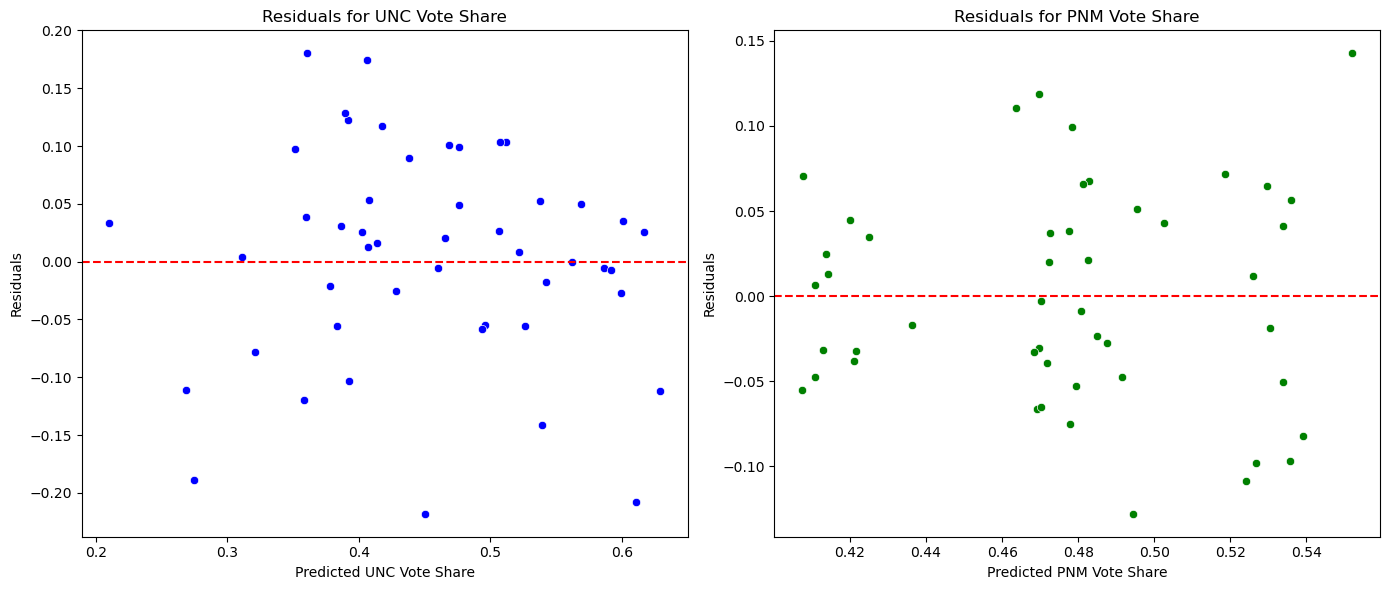

Mean Squared Error (MSE) for UNC: 0.008378920406809638
Mean Squared Error (MSE) for PNM: 0.00390717049752599
R-squared (R²) for UNC: 0.5078899907262198
R-squared (R²) for PNM: 0.3025220245054495


In [14]:
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Mean Squared Error for both UNC and PNM
mse_unc = mean_squared_error(actual_unc, predicted_unc)
mse_pnm = mean_squared_error(actual_pnm, predicted_pnm)

# R-squared for both UNC and PNM
r2_unc = r2_score(actual_unc, predicted_unc)
r2_pnm = r2_score(actual_pnm, predicted_pnm)

# Residuals for analysis
residuals_unc = actual_unc - predicted_unc
residuals_pnm = actual_pnm - predicted_pnm

# Plotting
plt.figure(figsize=(14, 6))

#  Residual plot for UNC
plt.subplot(1, 2, 1)
sns.scatterplot(x=predicted_unc, y=residuals_unc, color='blue')
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals for UNC Vote Share')
plt.xlabel('Predicted UNC Vote Share')
plt.ylabel('Residuals')

#  Residual plot for PNM
plt.subplot(1, 2, 2)
sns.scatterplot(x=predicted_pnm, y=residuals_pnm, color='green')
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals for PNM Vote Share')
plt.xlabel('Predicted PNM Vote Share')
plt.ylabel('Residuals')

# Show plots
plt.tight_layout()
plt.show()

# Print the evaluation metrics
print(f"Mean Squared Error (MSE) for UNC: {mse_unc}")
print(f"Mean Squared Error (MSE) for PNM: {mse_pnm}")
print(f"R-squared (R²) for UNC: {r2_unc}")
print(f"R-squared (R²) for PNM: {r2_pnm}")

In [15]:
# predicted winner based on the predicted vote shares
marginal_results_df_tuned['Predicted_Winner'] = np.where(
    marginal_results_df_tuned['Predicted_UNC_Vote_Share'] > marginal_results_df_tuned['Predicted_PNM_Vote_Share'], 
    'UNC',  # UNC wins if its actual vote share is greater
    'PNM'   # PNM wins if its actual vote share is greater
)

# actual winner based on the actual vote shares
marginal_results_df_tuned['Actual_Winner'] = np.where(
    marginal_results_df_tuned['Actual_UNC_Vote_Share'] > marginal_results_df_tuned['Actual_PNM_Vote_Share'], 
    'UNC',  # UNC wins if its actual vote share is greater
    'PNM'   # PNM wins if its actual vote share is greater
)

# predicted and actual winners for each constituency
print(marginal_results_df_tuned[['Constituency', 'Actual_Winner', 'Predicted_Winner']])

            Constituency Actual_Winner Predicted_Winner
0     BARATARIA/SAN JUAN           PNM              PNM
1         CHAGUANAS EAST           PNM              PNM
2      CUMUTO/MANZANILLA           UNC              PNM
3   LA HORQUETTA/TALPARO           PNM              PNM
4                 MAYARO           UNC              PNM
5       MORUGA/TABLELAND           PNM              PNM
6        POINTE-A-PIERRE           PNM              PNM
7      SAN FERNANDO WEST           PNM              PNM
8             ST. JOSEPH           PNM              PNM
9            TOBAGO EAST           PNM              PNM
10    TOCO/SANGRE GRANDE           PNM              PNM
11              TUNAPUNA           PNM              PNM
12    BARATARIA/SAN JUAN           UNC              UNC
13        CHAGUANAS EAST           UNC              UNC
14     CUMUTO/MANZANILLA           UNC              UNC
15  LA HORQUETTA/TALPARO           UNC              UNC
16                MAYARO           UNC          

In [16]:
# predicted winner based on the predicted vote shares
marginal_results_df_all['Predicted_Winner'] = np.where(
    marginal_results_df_all['Predicted_UNC_Vote_Share'] > marginal_results_df_all['Predicted_PNM_Vote_Share'], 
    'UNC',  # UNC wins if its actual vote share is greater
    'PNM'   # PNM wins if its actual vote share is greater
)

#actual winner based on the actual vote shares
marginal_results_df_all['Actual_Winner'] = np.where(
    marginal_results_df_all['Actual_UNC_Vote_Share'] > marginal_results_df_all['Actual_PNM_Vote_Share'], 
    'UNC',  # UNC wins if its actual vote share is greater
    'PNM'   # PNM wins if its actual vote share is greater
)

#predicted and actual winners for each constituency
print(marginal_results_df_all[['Constituency', 'Actual_Winner', 'Predicted_Winner']])

            Constituency Actual_Winner Predicted_Winner
0     BARATARIA/SAN JUAN           PNM              PNM
1         CHAGUANAS EAST           PNM              PNM
2      CUMUTO/MANZANILLA           UNC              PNM
3   LA HORQUETTA/TALPARO           PNM              PNM
4                 MAYARO           UNC              PNM
5       MORUGA/TABLELAND           PNM              PNM
6        POINTE-A-PIERRE           PNM              PNM
7      SAN FERNANDO WEST           PNM              PNM
8             ST. JOSEPH           PNM              PNM
9            TOBAGO EAST           PNM              PNM
10    TOCO/SANGRE GRANDE           PNM              PNM
11              TUNAPUNA           PNM              PNM
12    BARATARIA/SAN JUAN           UNC              UNC
13        CHAGUANAS EAST           UNC              UNC
14     CUMUTO/MANZANILLA           UNC              UNC
15  LA HORQUETTA/TALPARO           UNC              UNC
16                MAYARO           UNC          

In [17]:
normal_model_accuracy = (marginal_results_df_all['Predicted_Winner'] == marginal_results_df_all['Actual_Winner']).mean()
print(f"Normal Model Accuracy: {normal_model_accuracy:.2%}")

tuned_model_accuracy = (marginal_results_df_tuned['Predicted_Winner'] == marginal_results_df_tuned['Actual_Winner']).mean()
print(f"Tuned Model Accuracy: {tuned_model_accuracy:.2%}")

Normal Model Accuracy: 68.75%
Tuned Model Accuracy: 66.67%


In [ ]:
df_2025 = df_marginal_seats[df_marginal_seats['Year'] == 2024]  # Correcting to year 2025


X_2025 = df_2025[features]  # The same features used in training
y_2025_pred_tuned = best_model_marg.predict(X_2025)

predicted_unc_2025 = y_2025_pred_tuned[:, 0]  # UNC predictions (first column)
predicted_pnm_2025 = y_2025_pred_tuned[:, 1]  # PNM predictions (second column)

predicted_sum_2025 = predicted_unc_2025 + predicted_pnm_2025

# scale the predictions
if any(predicted_sum_2025 > 1):
    scale_factor = 1 / predicted_sum_2025
    predicted_unc_2025 = predicted_unc_2025 * scale_factor
    predicted_pnm_2025 = predicted_pnm_2025 * scale_factor

# re-create the DataFrame with the adjusted predictions
df_2025_predictions_with_tuning = pd.DataFrame({
    'Constituency': df_2025['CONSTITUENCIES'],
    'Predicted_UNC_Vote_Share_2025': predicted_unc_2025,
    'Predicted_PNM_Vote_Share_2025': predicted_pnm_2025
})

print("\n2025 Election Predictions(TUNING):\n")

actual_pnm = df_2025['P.N.M._VOTES_%'].values
actual_unc = df_2025['U.N.C._VOTES_%'].values

df_2025_predictions_with_tuning['Actual_UNC_Vote_Share'] = actual_unc
df_2025_predictions_with_tuning['Actual_PNM_Vote_Share'] = actual_pnm   
df_2025_predictions_with_tuning



2025 Election Predictions(TUNING):



,Constituency,Predicted_UNC_Vote_Share_2025,Predicted_PNM_Vote_Share_2025
48,BARATARIA/SAN JUAN,0.450627,0.549373
49,CHAGUANAS EAST,0.491972,0.508028
50,CUMUTO/MANZANILLA,0.537619,0.462381
51,LA HORQUETTA/TALPARO,0.512226,0.487774
52,MAYARO,0.516390,0.483610
53,MORUGA/TABLELAND,0.519765,0.480235
54,POINTE-A-PIERRE,0.464980,0.535020
55,SAN FERNANDO WEST,0.450301,0.549699
56,ST. JOSEPH,0.510640,0.489360
57,TOBAGO EAST,0.422147,0.577853


In [19]:
df_2025 = df_marginal_seats[df_marginal_seats['Year'] == 2024]  # Your 2025 inputs
X_2025 = df_2025[features]

y_2025_pred = reg.predict(X_2025)

# Extract UNC and PNM predictions
predicted_unc_2025 = y_2025_pred[:, 0]
predicted_pnm_2025 = y_2025_pred[:, 1]

predicted_sum_2025 = predicted_unc_2025 + predicted_pnm_2025
scale_factor = np.where(predicted_sum_2025 > 1, 1 / predicted_sum_2025, 1)

predicted_unc_2025 = predicted_unc_2025 * scale_factor
predicted_pnm_2025 = predicted_pnm_2025 * scale_factor

# DataFrame of 2025 predictions
df_2025_predictions_no_tuning = pd.DataFrame({
    'Constituency': df_2025['CONSTITUENCIES'],
    'Predicted_UNC_Vote_Share_2025': predicted_unc_2025,
    'Predicted_PNM_Vote_Share_2025': predicted_pnm_2025
})

print("\n2025 Election Predictions(NO TUNING):\n")
actual_unc = df_2025['U.N.C._VOTES_%'].values
actual_pnm = df_2025['P.N.M._VOTES_%'].values

df_2025_predictions_no_tuning['Actual_UNC_Vote_Share'] = actual_unc
df_2025_predictions_no_tuning['Actual_PNM_Vote_Share'] = actual_pnm
df_2025_predictions_no_tuning


2025 Election Predictions(NO TUNING):



,Constituency,Predicted_UNC_Vote_Share_2025,Predicted_PNM_Vote_Share_2025,Actual_UNC_Vote_Share,Actual_PNM_Vote_Share
48,BARATARIA/SAN JUAN,0.497332,0.502668,0.629035,0.335646
49,CHAGUANAS EAST,0.526162,0.473838,0.628196,0.330803
50,CUMUTO/MANZANILLA,0.567248,0.432752,0.682926,0.293257
51,LA HORQUETTA/TALPARO,0.542644,0.457356,0.566958,0.397019
52,MAYARO,0.546066,0.453934,0.703926,0.274344
53,MORUGA/TABLELAND,0.541591,0.458409,0.572854,0.412622
54,POINTE-A-PIERRE,0.504609,0.495391,0.645953,0.319705
55,SAN FERNANDO WEST,0.485125,0.514875,0.505648,0.457226
56,ST. JOSEPH,0.545038,0.454962,0.573015,0.385865
57,TOBAGO EAST,0.463107,0.536893,0.571109,0.351427


In [ ]:
df_2025_predictions_with_tuning['Predicted_Winning_Party'] = np.where(
    df_2025_predictions_with_tuning['Predicted_UNC_Vote_Share_2025'] > df_2025_predictions_with_tuning['Predicted_PNM_Vote_Share_2025'], 
    'U.N.C.',  # UNC wins if its actual vote share is greater
    'P.N.M.'   # PNM wins if its actual vote share is greater
)
# predicted and actual winners for each constituency
df_2025_predictions_to_concat_WT = df_2025_predictions_with_tuning[['Constituency', 'Predicted_Winning_Party', 'Predicted_UNC_Vote_Share_2025', 'Predicted_PNM_Vote_Share_2025']]
df_2025_predictions_to_concat_WT

,Constituency,Predicted_Winning_Party,Predicted_UNC_Vote_Share_2025,Predicted_PNM_Vote_Share_2025
48,BARATARIA/SAN JUAN,P.N.M.,0.450627,0.549373
49,CHAGUANAS EAST,P.N.M.,0.491972,0.508028
50,CUMUTO/MANZANILLA,U.N.C.,0.537619,0.462381
51,LA HORQUETTA/TALPARO,U.N.C.,0.512226,0.487774
52,MAYARO,U.N.C.,0.516390,0.483610
53,MORUGA/TABLELAND,U.N.C.,0.519765,0.480235
54,POINTE-A-PIERRE,P.N.M.,0.464980,0.535020
55,SAN FERNANDO WEST,P.N.M.,0.450301,0.549699
56,ST. JOSEPH,U.N.C.,0.510640,0.489360
57,TOBAGO EAST,P.N.M.,0.422147,0.577853


In [21]:
full_predictions_2025_WT = pd.concat([predictions_2025, df_2025_predictions_to_concat_WT], ignore_index=True)
full_predictions_2025_WT = full_predictions_2025_WT.sort_values(by='Constituency').reset_index(drop=True)
full_predictions_2025_WT

,Constituency,Predicted_Winning_Party,Predicted_UNC_Vote_Share_2025,Predicted_PNM_Vote_Share_2025
0,ARIMA,P.N.M.,NaN,NaN
1,AROUCA/MALONEY,P.N.M.,NaN,NaN
2,BARATARIA/SAN JUAN,P.N.M.,0.450627,0.549373
3,CARONI CENTRAL,U.N.C.,NaN,NaN
4,CARONI EAST,U.N.C.,NaN,NaN
5,CHAGUANAS EAST,P.N.M.,0.491972,0.508028
6,CHAGUANAS WEST,U.N.C.,NaN,NaN
7,COUVA NORTH,U.N.C.,NaN,NaN
8,COUVA SOUTH,U.N.C.,NaN,NaN
9,CUMUTO/MANZANILLA,U.N.C.,0.537619,0.462381


In [22]:
predicted_seat_counts = full_predictions_2025_WT['Predicted_Winning_Party'].value_counts()

# overall seat counts
print(predicted_seat_counts)

Predicted_Winning_Party
P.N.M.    22
U.N.C.    19
Name: count, dtype: int64


In [23]:
predicted_seat_counts =df_2025_predictions_to_concat_WT['Predicted_Winning_Party'].value_counts()
# marginal seat counts
print(predicted_seat_counts)

Predicted_Winning_Party
P.N.M.    6
U.N.C.    6
Name: count, dtype: int64


In [24]:
df_2025_predictions_no_tuning['Predicted_Winning_Party'] = np.where(
    df_2025_predictions_no_tuning['Predicted_UNC_Vote_Share_2025'] > df_2025_predictions_no_tuning['Predicted_PNM_Vote_Share_2025'], 
    'U.N.C.',  # UNC wins if its actual vote share is greater
    'P.N.M.'   # PNM wins if its actual vote share is greater
)
#actual winners for each constituency
df_2025_predictions_to_concat_NT = df_2025_predictions_no_tuning[['Constituency', 'Predicted_Winning_Party', 'Predicted_UNC_Vote_Share_2025', 'Predicted_PNM_Vote_Share_2025']]
df_2025_predictions_to_concat_NT


,Constituency,Predicted_Winning_Party,Predicted_UNC_Vote_Share_2025,Predicted_PNM_Vote_Share_2025
48,BARATARIA/SAN JUAN,P.N.M.,0.497332,0.502668
49,CHAGUANAS EAST,U.N.C.,0.526162,0.473838
50,CUMUTO/MANZANILLA,U.N.C.,0.567248,0.432752
51,LA HORQUETTA/TALPARO,U.N.C.,0.542644,0.457356
52,MAYARO,U.N.C.,0.546066,0.453934
53,MORUGA/TABLELAND,U.N.C.,0.541591,0.458409
54,POINTE-A-PIERRE,U.N.C.,0.504609,0.495391
55,SAN FERNANDO WEST,P.N.M.,0.485125,0.514875
56,ST. JOSEPH,U.N.C.,0.545038,0.454962
57,TOBAGO EAST,P.N.M.,0.463107,0.536893


In [25]:
full_predictions_2025_NT = pd.concat([predictions_2025, df_2025_predictions_to_concat_NT], ignore_index=True)

full_predictions_2025_NT = full_predictions_2025_NT.sort_values(by='Constituency').reset_index(drop=True)

# combined results
full_predictions_2025_NT

,Constituency,Predicted_Winning_Party,Predicted_UNC_Vote_Share_2025,Predicted_PNM_Vote_Share_2025
0,ARIMA,P.N.M.,NaN,NaN
1,AROUCA/MALONEY,P.N.M.,NaN,NaN
2,BARATARIA/SAN JUAN,P.N.M.,0.497332,0.502668
3,CARONI CENTRAL,U.N.C.,NaN,NaN
4,CARONI EAST,U.N.C.,NaN,NaN
5,CHAGUANAS EAST,U.N.C.,0.526162,0.473838
6,CHAGUANAS WEST,U.N.C.,NaN,NaN
7,COUVA NORTH,U.N.C.,NaN,NaN
8,COUVA SOUTH,U.N.C.,NaN,NaN
9,CUMUTO/MANZANILLA,U.N.C.,0.567248,0.432752


In [26]:
predicted_seat_counts = full_predictions_2025_NT['Predicted_Winning_Party'].value_counts()

# overall seat counts, including safe and marginal seats
print(predicted_seat_counts)

Predicted_Winning_Party
U.N.C.    22
P.N.M.    19
Name: count, dtype: int64


In [27]:
predicted_seat_counts =df_2025_predictions_to_concat_NT['Predicted_Winning_Party'].value_counts()
# seat counts for marginals
print(predicted_seat_counts)

Predicted_Winning_Party
U.N.C.    9
P.N.M.    3
Name: count, dtype: int64


In [28]:
# Example DataFrames
full_pred_NT = full_predictions_2025_NT
full_pred_WT = full_predictions_2025_WT
safe_seats = predictions_2025          # constituency-level predictions
marginals_NT = df_2025_predictions_to_concat_NT       #  overall seat counts
marginals_WT = df_2025_predictions_to_concat_WT    

# Write to a single Excel file with named sheets
with pd.ExcelWriter('2025_election_predictions.xlsx') as writer:
    full_pred_NT.to_excel(writer, sheet_name='Predictions NO Tuning', index=False)
    full_pred_WT.to_excel(writer, sheet_name='Predictions WITH Tuning', index=False)
    safe_seats.to_excel(writer, sheet_name='Safe Seats', index=False)
    marginals_NT.to_excel(writer, sheet_name='Marginal Seats NO Tuning', index=False)
    marginals_WT.to_excel(writer, sheet_name='Marginal Seats Tuning', index=False)

### Random Forest Classifier
#### 2025 Marginal Seats Prediction

Training

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import joblib
from sklearn.utils import resample

features = [
    'ELECTORATE', 'VOTER_TURNOUT', 'TOTAL_NUMBER_OF_VOTES_CAST', 'VALID_VOTES', 'GDP (Per Capita US$)',
    'Homicide_rate_per_100k', 'Inflation', 'Unemployment', 'SWING_PROB', 'Net Migration Rate', 'GDP_(US$)',
    'Growth Rate'
]

df_marginal_seats_model = df_marginal_seats[df_marginal_seats['Year'] != 2024]

X_marginal = df_marginal_seats_model[features]
y_marginal = df_marginal_seats_model['Winning_Party']  # Target variable: Party (UNC or PNM)

y_marginal_encoded = y_marginal.astype('category').cat.codes  # Encoding Winning Party (0 for PNM, 1 for UNC)

X_marginal_train, X_marginal_test, y_marginal_train, y_marginal_test = train_test_split(
    X_marginal, y_marginal_encoded, test_size=0.40, random_state=42, stratify=y_marginal_encoded
)

scaler = StandardScaler()
X_marginal_train_scaled = scaler.fit_transform(X_marginal_train)
X_marginal_test_scaled = scaler.transform(X_marginal_test)

rf = RandomForestClassifier(random_state=42, class_weight='balanced', n_estimators=100)

rf.fit(X_marginal_train_scaled, y_marginal_train)

y_marginal_pred_rf = rf.predict(X_marginal_test_scaled)

print("\nClassification Report for Safe Seats (Random Forest):\n")
print(classification_report(y_marginal_test, y_marginal_pred_rf))

print("\nConfusion Matrix for Safe Seats (Random Forest):\n")
print(confusion_matrix(y_marginal_test, y_marginal_pred_rf))




Classification Report for Safe Seats (Random Forest):

              precision    recall  f1-score   support

           0       0.69      0.90      0.78        10
           1       0.86      0.60      0.71        10

    accuracy                           0.75        20
   macro avg       0.77      0.75      0.74        20
weighted avg       0.77      0.75      0.74        20


Confusion Matrix for Safe Seats (Random Forest):

[[9 1]
 [4 6]]


['random_forest_safe_seats_model.pkl']

Prediction

In [30]:
df_2025 = df_marginal_seats[df_marginal_seats['Year'] == 2024]  # Filter for 2025 data
X_2025 = df_2025[features]

X_2025_scaled = scaler.transform(X_2025)


y_2025_pred = rf.predict(X_2025_scaled)

y_2025_pred_decoded = pd.Categorical.from_codes(y_2025_pred, categories=y_marginal.unique())

# add the predictions to the 2025 DataFrame
df_2025.loc[:, 'Predicted_Winning_Party'] = y_2025_pred_decoded


# Display the predictions
print("\n2025 Predictions for Safe Seats:\n")
print(df_2025[['CONSTITUENCIES', 'Predicted_Winning_Party']])


2025 Predictions for Safe Seats:

          CONSTITUENCIES Predicted_Winning_Party
48    BARATARIA/SAN JUAN          U.N.C._VOTES_%
49        CHAGUANAS EAST          U.N.C._VOTES_%
50     CUMUTO/MANZANILLA          U.N.C._VOTES_%
51  LA HORQUETTA/TALPARO          U.N.C._VOTES_%
52                MAYARO          P.N.M._VOTES_%
53      MORUGA/TABLELAND          U.N.C._VOTES_%
54       POINTE-A-PIERRE          U.N.C._VOTES_%
55     SAN FERNANDO WEST          U.N.C._VOTES_%
56            ST. JOSEPH          U.N.C._VOTES_%
57           TOBAGO EAST          P.N.M._VOTES_%
58    TOCO/SANGRE GRANDE          P.N.M._VOTES_%
59              TUNAPUNA          P.N.M._VOTES_%


C:\Users\maian\AppData\Local\Temp\ipykernel_34376\2314232910.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2025.loc[:, 'Predicted_Winning_Party'] = y_2025_pred_decoded


### Support Vector Machine

##### 2025 Marginal Seats Prediction

Training

In [31]:
from sklearn import metrics
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd


features = [ 'Homicide (Annual Percentage Change)', 'Inflation', 'Net Migration Rate',
            'Inflation_1t', 'Inflation_1y', 'Unemployment_1t', 'Unemployment_1y', 'Net Migration Rate_1t', 'Net Migration Rate_1y', 
            'GDP (Per Capita US$)_1t', 'GDP (Per Capita US$)_1y', 'GDP_(US$)_1t', 'GDP_(US$)_1y']


df_marginal_seats_model = df_marginal_seats[df_marginal_seats['Year'] != 2024]

X_marginal = df_marginal_seats_model[features]
y_marginal = df_marginal_seats_model[['U.N.C._VOTES_%', 'P.N.M._VOTES_%']]  # Two targets

# train-test split
X_marginal_train, X_marginal_test, y_marginal_train, y_marginal_test = train_test_split(
    X_marginal, y_marginal, test_size=0.40, random_state=42
)


scaler = StandardScaler()
X_marginal_train_scaled = scaler.fit_transform(X_marginal_train)
X_marginal_test_scaled = scaler.transform(X_marginal_test)

# SVR Model (with MultiOutputRegressor)
svr = SVR(kernel='rbf')  
multi_output_svr = MultiOutputRegressor(svr)

# Train
multi_output_svr.fit(X_marginal_train_scaled, y_marginal_train)

# Predict
y_marginal_pred = multi_output_svr.predict(X_marginal_test_scaled)

# Evaluate
mse_unc = mean_squared_error(y_marginal_test['U.N.C._VOTES_%'], y_marginal_pred[:, 0])
r2_unc = r2_score(y_marginal_test['U.N.C._VOTES_%'], y_marginal_pred[:, 0])

mse_pnm = mean_squared_error(y_marginal_test['P.N.M._VOTES_%'], y_marginal_pred[:, 1])
r2_pnm = r2_score(y_marginal_test['P.N.M._VOTES_%'], y_marginal_pred[:, 1])

# Print the results
print(f"Mean Squared Error (UNC): {mse_unc:.4f}")
print(f"R^2 score (UNC): {r2_unc:.4f}")
print(f"Mean Squared Error (PNM): {mse_pnm:.4f}")
print(f"R^2 score (PNM): {r2_pnm:.4f}")

SEE_unc = np.sqrt(np.sum(residuals_unc**2) / (len(y_marginal_test) - 2))  # Degrees of freedom
print(f"Standard Error of Estimate (UNC): {SEE_unc:.4f}")
SEE_pnm = np.sqrt(np.sum(residuals_pnm**2) / (len(y_marginal_test) - 2))  # Degrees of freedom
print(f"Standard Error of Estimate (PNM): {SEE_pnm:.4f}")


Mean Squared Error (UNC): 0.0115
R^2 score (UNC): 0.4061
Mean Squared Error (PNM): 0.0056
R^2 score (PNM): 0.1469
Standard Error of Estimate (UNC): 0.1495
Standard Error of Estimate (PNM): 0.1021


Prediction

In [32]:
X_2025_raw = df_marginal_seats[df_marginal_seats['Year'] == 2024]

X_2025 = X_2025_raw[features]

# 2. Scale X_2025 using the SAME scaler
X_2025_scaled = scaler.transform(X_2025)

y_2025_pred = multi_output_svr.predict(X_2025_scaled)

actual_pnm_2025 = X_2025_raw['P.N.M._VOTES_%'].values
actual_unc_2025 = X_2025_raw['U.N.C._VOTES_%'].values

predicted_2025_df = pd.DataFrame({
    'Constituency': X_2025_raw['CONSTITUENCIES'].values,
    'Predicted_UNC_Vote_Share': y_2025_pred[:, 0],
    'Actual_UNC_Vote_Share': actual_unc_2025,
    'Predicted_PNM_Vote_Share': y_2025_pred[:, 1],
    'Actual_PNM_Vote_Share': actual_pnm_2025
})

# 5. Predict seat winner
predicted_2025_df['Predicted_Winner'] = predicted_2025_df.apply(
    lambda row: 'UNC' if row['Predicted_UNC_Vote_Share'] > row['Predicted_PNM_Vote_Share'] else 'PNM',
    axis=1
)

print(predicted_2025_df)

seat_counts = predicted_2025_df['Predicted_Winner'].value_counts()
#predicted winners
seat_counts


            Constituency  Predicted_UNC_Vote_Share  Actual_UNC_Vote_Share  \
0     BARATARIA/SAN JUAN                  0.457865               0.629035   
1         CHAGUANAS EAST                  0.457865               0.628196   
2      CUMUTO/MANZANILLA                  0.457865               0.682926   
3   LA HORQUETTA/TALPARO                  0.457865               0.566958   
4                 MAYARO                  0.457865               0.703926   
5       MORUGA/TABLELAND                  0.457865               0.572854   
6        POINTE-A-PIERRE                  0.457865               0.645953   
7      SAN FERNANDO WEST                  0.457865               0.505648   
8             ST. JOSEPH                  0.457865               0.573015   
9            TOBAGO EAST                  0.457865               0.571109   
10    TOCO/SANGRE GRANDE                  0.457865               0.552131   
11              TUNAPUNA                  0.457865               0.529887   

Predicted_Winner
PNM    12
Name: count, dtype: int64

### Decision Tree Classifier 
#### 2025 Marginal Prediction

Training

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import joblib

features = [
    'CONSTITUENCY_LEANING', 'Year', 'Homicide (Annual Percentage Change)', 'Inflation_1t', 'Inflation_1y', 
    'Unemployment_1t', 'Unemployment_1y', 'Net Migration Rate_1t', 'Net Migration Rate_1y',
    'GDP (Per Capita US$)_1t', 'GDP (Per Capita US$)_1y', 'GDP_(US$)_1t', 'GDP_(US$)_1y',
    'ELECTORATE', 'ELASTICITY', 'SWING_PROB'
]

df_marginal_seats_model = df_marginal_seats[df_marginal_seats['Year'] != 2024]

X_marginal = df_marginal_seats_model[features]
y_marginal = df_marginal_seats_model['Winning_Party']  # Target: Winning Party (PNM or UNC)

# Encode target (binary classification)
y_marginal_encoded = y_marginal.astype('category').cat.codes  # 0 = PNM, 1 = UNC

# Split the data into training and test sets with fixed random_state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X_marginal, y_marginal_encoded, random_state=42, stratify=y_marginal_encoded)

param_grid = {
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)

best_params = grid_search.best_params_
dt_classifier = DecisionTreeClassifier(**best_params, random_state=42, class_weight='balanced')  # Use best params from grid search

# Train the model with best parameters
dt_classifier.fit(X_train, y_train)

# Make predictions
y_pred = dt_classifier.predict(X_test)

# Classification report
print("\nClassification Report for Decision Tree:\n")
print(classification_report(y_test, y_pred))

# Confusion matrix
print("\nConfusion Matrix for Decision Tree:\n")
print(confusion_matrix(y_test, y_pred))


Best Parameters: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5}

Classification Report for Decision Tree:

              precision    recall  f1-score   support

           0       0.83      0.83      0.83         6
           1       0.83      0.83      0.83         6

    accuracy                           0.83        12
   macro avg       0.83      0.83      0.83        12
weighted avg       0.83      0.83      0.83        12


Confusion Matrix for Decision Tree:

[[5 1]
 [1 5]]


['decision_tree_model_best.pkl']

Prediction

In [34]:
# Assuming df_2025 contains data for 2025
df_2025 = df_marginal_seats[df_marginal_seats['Year'] == 2024]
X_2025 = df_2025[features]

# Predict for 2025 constituencies
y_2025_pred = dt_classifier.predict(X_2025)

# Decode the numeric predictions back to the original labels
# Mapping predictions (0 -> PNM, 1 -> UNC)
prediction_map = {0: 'PNM', 1: 'UNC'}
y_2025_pred_decoded = [prediction_map[pred] for pred in y_2025_pred]

# Add predictions to the DataFrame
df_2025['Predicted_Winning_Party'] = y_2025_pred_decoded

# Show the predictions
print("\n2025 Predictions for Safe Seats (Decision Tree):\n")
print(df_2025[['CONSTITUENCIES', 'Predicted_Winning_Party']])



2025 Predictions for Safe Seats (Decision Tree):

          CONSTITUENCIES Predicted_Winning_Party
48    BARATARIA/SAN JUAN                     UNC
49        CHAGUANAS EAST                     UNC
50     CUMUTO/MANZANILLA                     PNM
51  LA HORQUETTA/TALPARO                     UNC
52                MAYARO                     PNM
53      MORUGA/TABLELAND                     UNC
54       POINTE-A-PIERRE                     UNC
55     SAN FERNANDO WEST                     UNC
56            ST. JOSEPH                     UNC
57           TOBAGO EAST                     PNM
58    TOCO/SANGRE GRANDE                     PNM
59              TUNAPUNA                     UNC


C:\Users\maian\AppData\Local\Temp\ipykernel_34376\2120384754.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2025['Predicted_Winning_Party'] = y_2025_pred_decoded
